- Quntile rank
    - https://www.geeksforgeeks.org/quantile-and-decile-rank-of-a-column-in-pandas-python/

In [17]:
from matplotlib import font_manager, rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("always")
warnings.filterwarnings(action='ignore')

sns.set(font_scale=1.4)
# 한글 폰트 사용을 위해서 세팅
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

pd.set_option('display.max_columns', 500)

df_2019_2021 = pd.read_csv('./data/data_2019_2021_revised.csv')


In [18]:
## 그룹 나누기 위해 discrete하게 만들기

df = df_2019_2021.copy() 

# 가구주 연령 Quintile Ranking
df['가구주_연령_Q5'] = pd.qcut(df['가구주_연령'], 5, labels=False).apply(lambda x: x+1)

# 입주형태코드
df['입주형태코드'] = df['입주형태코드'].replace({1:'자기집', 2:'무상주택', 3:'사택', 4:'전세', 5:'영구임대', 6:'보증부 월세', 7:'보증금 없는 월세'})

In [19]:
# 소비지출 상위 5개
cols_sobi_top5 = ['소비_식료품비주류음료구입비', '소비_주거수도광열비', '소비_음식숙박비', '소비_보건제품구입비', '소비_교통비']
df['소비_식료품비주류음료구입비'] = df['식료품비주류음료구입비']
df['소비_주거수도광열비'] = df['주거수도광열비']
df['소비_음식숙박비'] = df['음식숙박비']
df['소비_보건제품구입비'] = df['보건제품구입비']
df['소비_교통비'] = df['교통비']

# 소비지출 병합 5개
cols_sobi_combined5 = ['식료품 및 의류', '주거', '문화', '보건', '교통']
df['식료품 및 의류'] = df['식료품비주류음료구입비']+df['주류담배구입비']+df['의류신발구입비']
df['주거'] = df['주거수도광열비']+df['가정용품가사서비스이용금액']+df['통신비']+df['기타상품서비스이용금액']
df['문화'] = df['오락문화비']+df['음식숙박비']+df['교육비']
df['보건'] = df['보건제품구입비']
df['교통'] = df['교통비']

# 비소비지출 병합 4개
cols_bisobi_combined4 = ['비소비_조세', '비소비_연금_보험', '비소비_이자', '비소비_이전지출']
df['비소비_조세'] = df['_경상조세']+df['_비경상조세']
df['비소비_연금_보험'] = df['_연금기여금']+df['_사회보험료']
df['비소비_이자'] = df['_이자비용']
df['비소비_이전지출'] = df['_가구간이전지출금액']+df['_비영리단체이전지출금액']


In [20]:
def quantile_plot(df, col_range1, col_range2, col):
    l = pd.DataFrame(df[df[col]  <=  np.quantile(df[col], 0.01)].iloc[:, col_range1:col_range2].sum(axis = 0)).T.columns
    ll = []
    for i in range(100):
        data = pd.DataFrame(
         
            df[(df[col]  >  np.quantile(df[col], np.linspace(0, 1, 101)[i])) &
                             (df[col]  <=  np.quantile(df[col], np.linspace(0, 1, 101)[i+1]))].iloc[:, col_range1:col_range2].sum(axis = 0) / \
            
            df[(df[col]  >  np.quantile(df[col], np.linspace(0, 1, 101)[i])) &
                             (df[col]  <=  np.quantile(df[col], np.linspace(0, 1, 101)[i+1]))].loc[:, '가계지출금액'].sum(axis = 0)
        ).T
                
        ll.append(data.values)
        
    ll = pd.DataFrame(np.squeeze(ll))
    ll.columns = l    
    #ll = ll.iloc[:, 1:]
    return ll

In [21]:
def plot_all(df, col_x, col_y):

    plt.rcParams["figure.figsize"] = (10, 6)

    col_range1 = df.columns.tolist().index(col_y[0])
    col_range2 = df.columns.tolist().index(col_y[-1])+1
    Cluster_household_1 = quantile_plot(
        df, col_range1=col_range1, col_range2=col_range2, col=col_x)

    g = sns.lineplot(data=Cluster_household_1, palette="bone", linewidth=2.5)
    g.legend(bbox_to_anchor=(1.5, 0.5), loc='right')
    g.set_title("전체 가구")
    g.set_ylabel('소비(%)')
    g.set_xlabel(f'{col_x}')

    # plt.savefig('Household_finance_portfolio.png', dpi = 500)
    plt.show()


In [22]:
def plot_group(df, col_x, col_y, col_group):

    for here in sorted(df[col_group].unique()):
            
        plt.rcParams["figure.figsize"] = (5, 2)

        dfdf = df[(df[col_group] == here)]

        col_range1 = df.columns.tolist().index(col_y[0])
        col_range2 = df.columns.tolist().index(col_y[-1])+1
        Cluster_household_1  = quantile_plot(dfdf , col_range1 = col_range1, col_range2 = col_range2, col = col_x)

        plt.figure()
        g = sns.lineplot(data=Cluster_household_1, palette="bone", linewidth=2.5)
        #g.legend(bbox_to_anchor=(2.5, 0.5), loc='right') # 1.5 0.5
        g.get_legend().remove()
        g.set_title(f"소득구간 {here}")
        g.set_ylabel('소비(%)')
        g.set_xlabel(f'{col_x}')

        plt.savefig('{}.png'.format(here), dpi = 500, bbox_inches='tight') # bbox_inches='tight'
        # plt.show()

# 전체가구

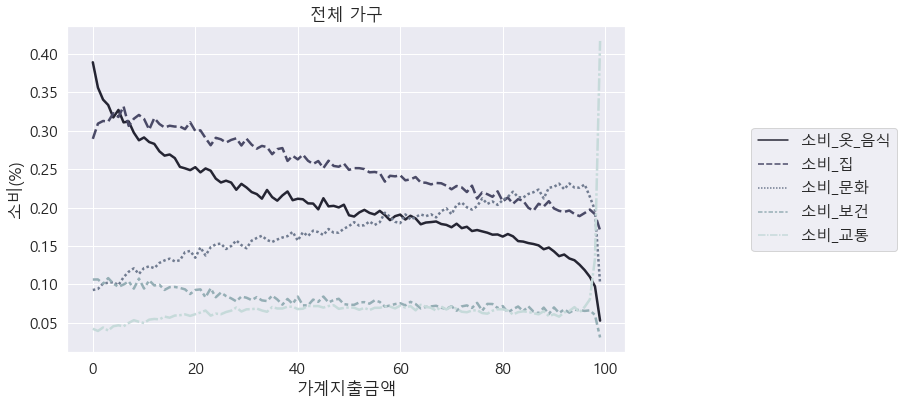

In [20]:
# cols_sobi_top5, cols_sobi_combined5, cols_bisobi_combined4
plot_all(df, '가계지출금액', cols_sobi_combined5)


# (전체가구, 한줄씩)

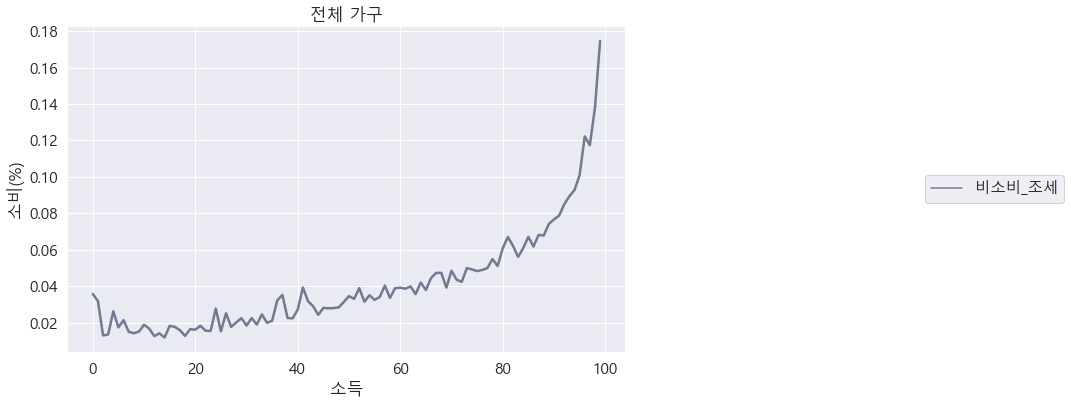

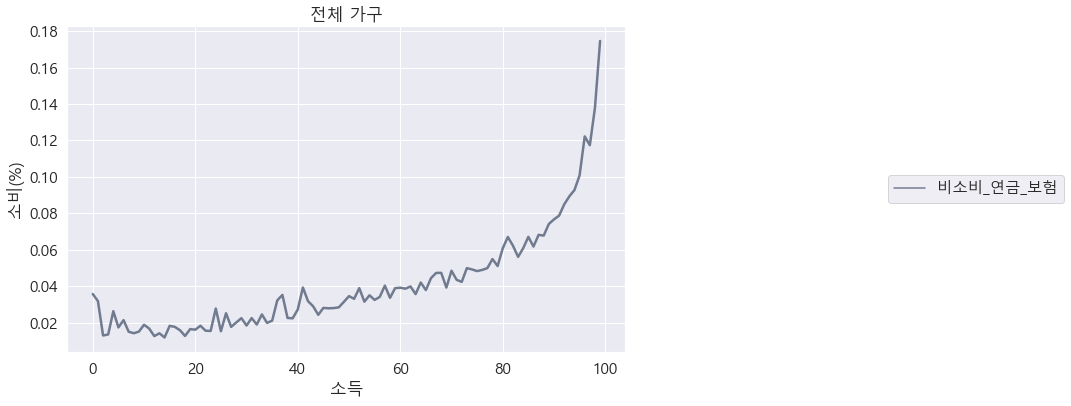

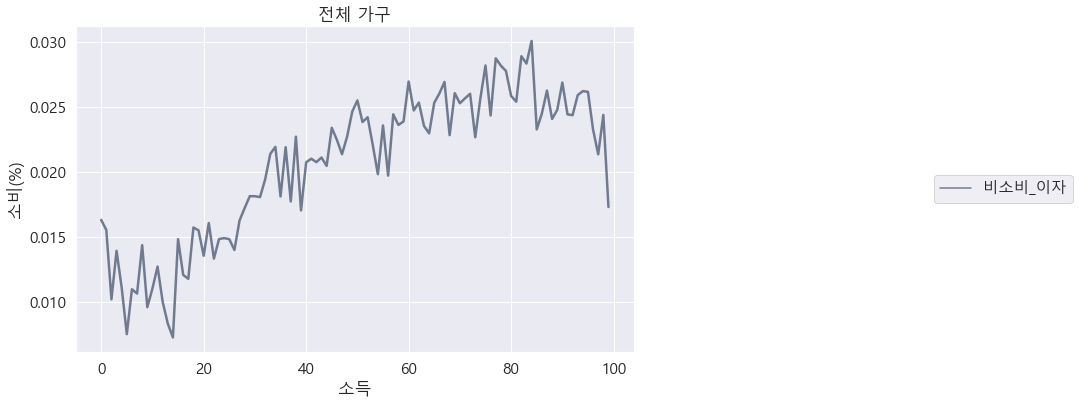

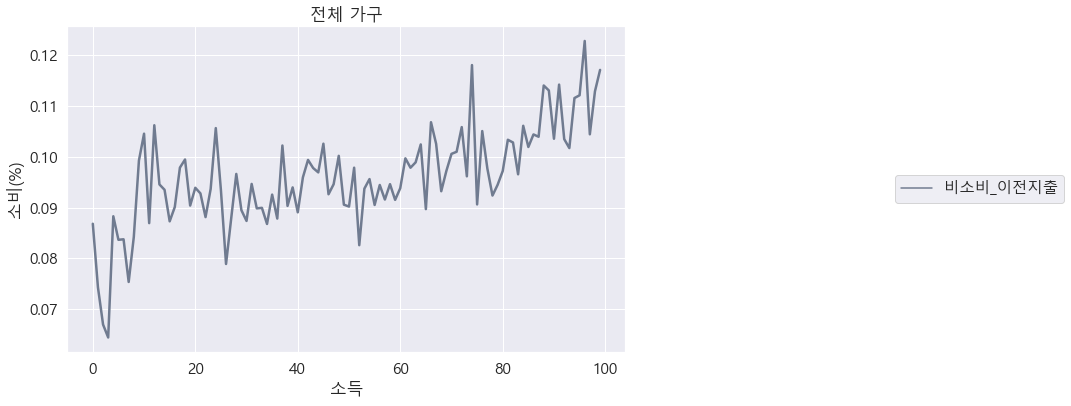

In [ ]:
for col in cols_bisobi_combined4:
    
    col_x = '소득'

    plt.rcParams["figure.figsize"] = (10, 6)

    col_range1 = df.columns.tolist().index(cols_bisobi_combined4[0])
    col_range2 = df.columns.tolist().index(cols_bisobi_combined4[-1])+1
    Cluster_household_1  = quantile_plot(df , col_range1 = col_range1, col_range2 = col_range2, col = col_x)

    Cluster_household_1 = pd.DataFrame(Cluster_household_1[col])

    g = sns.lineplot(data=Cluster_household_1, palette="bone", linewidth=2.5)
    g.legend(bbox_to_anchor=(1.8, 0.5), loc='right')
    g.set_title("전체 가구")
    g.set_ylabel('소비(%)')
    g.set_xlabel(f'{col_x}')

    # plt.savefig('Household_finance_portfolio.png', dpi = 500)
    plt.show()

# 그룹가구

In [7]:
# 소득구간코드 역순으로 바꾸기: 1에 가까울 수록 고소득이 되도록 해서 클러스터 번호랑 맞춘다

as_is_list = range(1, 9)
to_be_list = reversed(range(1,9))
replacing_dict = dict(zip(as_is_list, to_be_list))
df['소득구간코드'] = df['소득구간코드'].replace(replacing_dict)

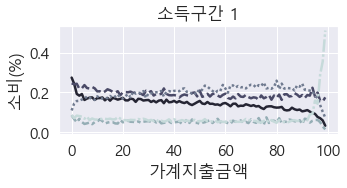

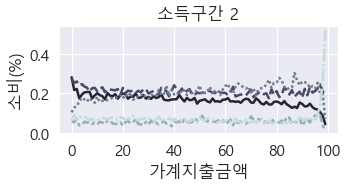

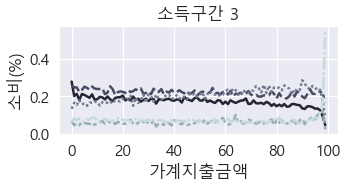

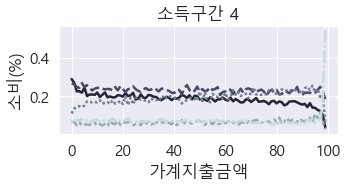

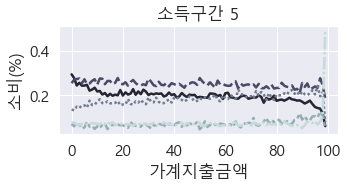

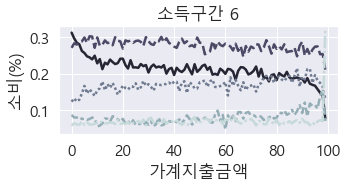

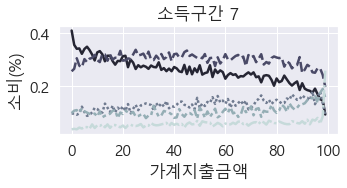

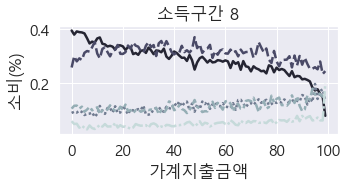

In [11]:
# cols_sobi_top5, cols_sobi_combined5, cols_bisobi_combined4
plot_group(df, '가계지출금액', cols_sobi_combined5, '소득구간코드') # 전국전체가구_1인이상소득10분위코드

# 클러스터 

In [23]:
# 클러스터 라벨
k=9
pred = pd.read_csv('clustering_results/pred_HC_e50_k9_v1.csv')
df['cluster']=pred.values

# 클러스터 관측 수 많은 순으로 정렬 # as_is_list = df.cluster.value_counts().keys()
# 소득 많은 순으로 정렬 # # df.groupby('cluster')['소득'].mean().sort_values(ascending=False).index
as_is_list = df.groupby('cluster')['소득'].mean().sort_values(ascending=False).index
to_be_list = range(1, k+1)
replacing_dict = dict(zip(as_is_list, to_be_list))
df['cluster'] = df['cluster'].replace(replacing_dict)

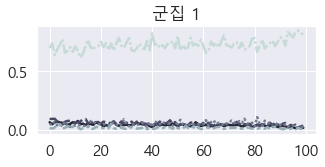

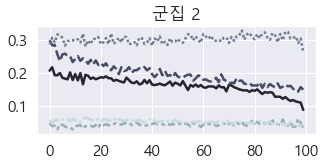

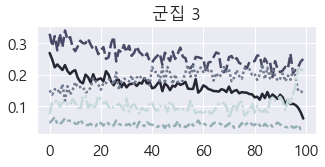

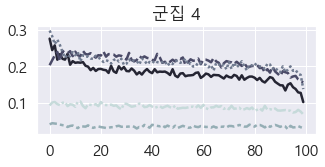

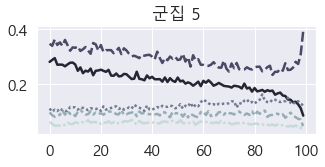

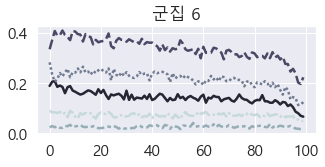

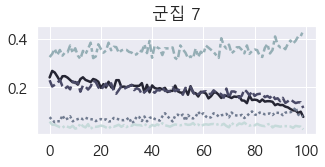

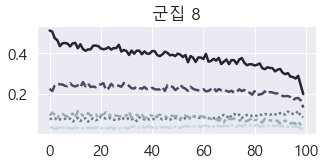

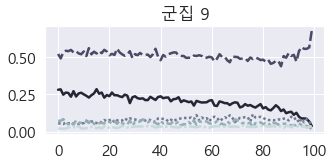

In [17]:
plot_group(df, '가계지출금액', cols_sobi_combined5, 'cluster')


In [24]:
df['cluster'].value_counts()

4    15632
5    12170
2    11333
8    10167
3     6886
7     5619
6     5602
9     4374
1      447
Name: cluster, dtype: int64